In [5]:
#May or May Not Need to Run
%pip install dataretrieval
%pip install folium

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from dataretrieval import nwis
from IPython.display import display
#from datetime import date, timedelta
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#import pytide
import seaborn as sns
import numpy as np
from ttide.t_tide import t_tide
import csv

In [2]:
def get_data(siteIDs, parameterCode, start_yr, end_yr, startDate='-01-01', endDate = '-12-31'):
    results = []
    for i in range(start_yr,(int(end_yr)+1)):
        data = nwis.get_iv(sites=siteIDs, parameterCd=parameterCode, start=(str(i)+startDate), end=(str(i)+endDate))
        data[0].drop(data[0].columns[[1]], axis = 1, inplace=True)
        results.append(data[0])
    results = pd.concat(results)
    return results

In [3]:
def gage_ID_from_csv(file_name):
    gages_df = pd.read_csv(file_name)
    #gages_df['end_date'] = pd.to_datetime(gages_df['end_date'], format = '%Y-%m-%d')
    gages_df['end_date'] = pd.to_datetime(gages_df['end_date'], format = '%m/%d/%Y')
    gages = gages_df[gages_df['end_date'].dt.year > start_yr]
    gages['site_no'] = gages['site_no'].astype(int)
    gages['site_no'] = gages['site_no'].apply(lambda x: '{0:0>8}'.format(x))
    site_ids = list(gages['site_no'].unique())
    return gages[['site_no', 'dec_lat_va', 'dec_long_va']], site_ids

In [4]:
def tide_pred(results, gage_loc, year=None, amp_threshold = 0.2):
    if len(results.index.name) == 1:
        if (year is not None):
            if year in tide_subset.index.year:
                tide_analys=tide_subset[tide_subset.index.year==year]
                tide_analys.reset_index(inplace=True)
            else:
                pass
        else:
            tide_analys = tide_subset
            tide_analys.reset_index(inplace=True)
        #startdate = tide_analys['datetime'][0]
        #enddate = startdate + timedelta(days=7)
        stream_data = tide_analys.groupby([pd.Grouper(key='datetime', freq='H'),'site_no']).mean()
        stream_data.reset_index(inplace=True)
        
        stream_data['demean'] = stream_data['00065'] - stream_data['00065'].mean()
        #tfit_e = t_tide(stream_data['demean'].values, out_style='classic')

        tfit_e = t_tide(stream_data['demean'].values, out_style='none')
        if sum([i[0]for i in tfit_3['tidecon']]) > amp_threshold:
            gage_loc['Influence'] = 'Tidal'
        else:
            gage_loc['Influence'] = 'None'


    else:
        for i in results.index.levels[0]:
            tide_subset = results.loc[[i]].copy()
            tide_subset.reset_index(inplace=True)
            tide_subset.set_index('datetime',inplace=True)
            if (year is not None):
                if year in tide_subset.index.year:
                    tide_analys=tide_subset[tide_subset.index.year==year]
                    tide_analys.reset_index(inplace=True)
                else:
                    continue
            else:
                tide_analys = tide_subset
                tide_analys.reset_index(inplace=True)
            #startdate = tide_analys['datetime'][0]
            #enddate = startdate + timedelta(days=7)
            stream_data = tide_analys.groupby([pd.Grouper(key='datetime', freq='H'),'site_no']).mean()
            stream_data.reset_index(inplace=True)
            
            stream_data['demean'] = stream_data['00065'] - stream_data['00065'].mean()
            #tfit_e = t_tide(stream_data['demean'].values, out_style='classic')

            tfit_e = t_tide(stream_data['demean'].values, out_style='none')
            
            if sum([i[0]for i in tfit_3['tidecon']]) > amp_threshold:
                gage_loc['Influence'] = 'Tidal'
            else:
                gage_loc['Influence'] = 'None'

    
        return gage_loc


In [15]:
#WORKS FOR SINGLE STATION
'''
def tide_pred(results,year):
    tide_analys=results[results.index.year==year]
    tide_analys.reset_index(inplace=True)
    
    #startdate = tide_analys['datetime'][0]
    #enddate = startdate + timedelta(days=7)
    stream_data = tide_analys.groupby([pd.Grouper(key='datetime', freq='H'),'site_no']).mean()
    stream_data.reset_index(inplace=True)

    wt= pytide.WaveTable()
    time = stream_data['datetime'].dt.to_pydatetime()
    
    f, vu = wt.compute_nodal_modulations(time.astype("datetime64"))
    w = wt.harmonic_analysis(stream_data['00065'], f, vu)
    #w = wt.harmonic_analysis(discharge['00060'], f, vu)
    hp = wt.tide_from_tide_series(time.astype("datetime64"), w)
    #tidal_results = pd.DataFrame(hp)


    #tidal_results = pd.DataFrame(hp)
 
# save the dataframe as a csv file
    
    return hp
'''

In [7]:
# Set the parameters needed for the web service call

#parameterCode = '00060'  # Discharge (mean, daily - ft^3/sec)
#parameterCode = '00061'  # Discharge (instantaneous - ft^3/sec)
parameterCode = '00065'   #Gage Heights (ft)
#startDate = '-07-01'
#endDate = '-07-30'
start_yr = 2018
end_yr = 2022

#gages, stations = gage_ID_from_csv(r'C:\PROJECTS\WRAP\Tide_Infl\NJ-2_Gage_Sites.csv')
gages, stations = gage_ID_from_csv(r'NJ-2_Gage_Sites.csv')
results=get_data(stations, parameterCode, start_yr, end_yr)
#ttide_results = tide_pred(results, gages)

display(results.head())
#still need to assign_attrib as tidal vs. non-tidal


/var/folders/1l/2r02jwq11s19l91rj_gktc9m6cb00_/T/ipykernel_1388/2569509585.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gages['site_no'] = gages['site_no'].astype(int)
/var/folders/1l/2r02jwq11s19l91rj_gktc9m6cb00_/T/ipykernel_1388/2569509585.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gages['site_no'] = gages['site_no'].apply(lambda x: '{0:0>8}'.format(x))


00065
site_no  datetime                        
01367715 2018-06-22 17:30:00+00:00   1.75
         2018-06-22 17:45:00+00:00   1.75
         2018-06-22 18:00:00+00:00   1.75
         2018-06-22 18:15:00+00:00   1.75
         2018-06-22 18:30:00+00:00   1.75

In [8]:
###FOR DEMO PURPOSES RUN THIS CODE BLOCK###
#Still cleaning up some of the logic functions in the tide_pred function
#Need to fix loop for running multiple gages in this demo block - only outputting results for one gage currently
gage_loc = pd.DataFrame()
for i in results.index.levels[0]:
#for i in results_test.index.levels[0]:
    tide_subset = results.loc[[i]].copy()
    #tide_subset = results_test.loc[[i]].copy()
    tide_subset.reset_index(inplace=True)
    tide_subset.set_index('datetime',inplace=True)


    display(tide_subset.head)
    tide_subset.reset_index(inplace=True)
    tide_subset.set_index('datetime',inplace=True)



    tide_analys = tide_subset
    tide_analys.reset_index(inplace=True)
    stream_data = tide_analys.groupby([pd.Grouper(key='datetime', freq='H'),'site_no']).mean()
    stream_data.reset_index(inplace=True)

    stream_data['demean'] = stream_data['00065'] - stream_data['00065'].mean()
            #tfit_e = t_tide(stream_data['demean'].values, out_style='classic')

    t_fit = t_tide(stream_data['demean'].values, out_style='pandas')

    print(stream_data['site_no'].unique())
    gage_loc['site_no'] = stream_data['site_no'].unique()
    amp_threshold = 0.2
    if sum([i[0]for i in t_fit['tidecon']]) > amp_threshold:
        gage_loc['Influence'] = 'Tidal'
    else:
        gage_loc['Influence'] = 'None'
    
display(gage_loc)

#Appending Gage information to include lat long

<bound method NDFrame.head of                             site_no  00065
datetime                                  
2018-06-22 17:30:00+00:00  01367715   1.75
2018-06-22 17:45:00+00:00  01367715   1.75
2018-06-22 18:00:00+00:00  01367715   1.75
2018-06-22 18:15:00+00:00  01367715   1.75
2018-06-22 18:30:00+00:00  01367715   1.75
...                             ...    ...
2023-01-01 03:45:00+00:00  01367715   2.44
2023-01-01 04:00:00+00:00  01367715   2.44
2023-01-01 04:15:00+00:00  01367715   2.45
2023-01-01 04:30:00+00:00  01367715   2.46
2023-01-01 04:45:00+00:00  01367715   2.46

[146248 rows x 2 columns]>

Number of observations = 36570
Number of observations used = 36569
Record length (days) = 1523.75
Phases at central time

x0= 0.00864  xtrend= 0
var(data)= 0.26    var(prediction)= 0.03    var(residual)= 0.23
var(prediction)/var(data) (%) = 10.7

            Tidal amplitude and phase with 95 % CI estimates
                 Freq        Amp    Amp Err      Phase  Phase Err        SNR
Tide                                                                        
SA           0.000114       0.23       0.07      152.6       16.9      1e+01
SSA          0.000228       0.06       0.06      248.4       73.2          1
MSM          0.001310       0.04       0.05      159.1       91.7        0.6
MM           0.001512       0.03       0.05      209.7      134.0        0.3
MSF          0.002822       0.02       0.06      284.8      162.6       0.08
MF           0.003050       0.01       0.04      328.6      241.8       0.02
ALP1         0.034397       0.00       0.00      212.4       79.0        0.9

<bound method NDFrame.head of                             site_no  00065
datetime                                  
2018-01-01 05:00:00+00:00  01377000   1.66
2018-01-01 05:15:00+00:00  01377000   1.66
2018-01-01 05:30:00+00:00  01377000   1.66
2018-01-01 05:45:00+00:00  01377000   1.66
2018-01-01 06:00:00+00:00  01377000   1.66
...                             ...    ...
2023-01-01 03:45:00+00:00  01377000   1.77
2023-01-01 04:00:00+00:00  01377000   1.77
2023-01-01 04:15:00+00:00  01377000   1.78
2023-01-01 04:30:00+00:00  01377000   1.78
2023-01-01 04:45:00+00:00  01377000   1.78

[175066 rows x 2 columns]>

Number of observations = 43776
Number of observations used = 43775
Record length (days) = 1824.00
Phases at central time

x0= -5.5e-05  xtrend= 0
var(data)= 0.19    var(prediction)= 0.00    var(residual)= 0.19
var(prediction)/var(data) (%) = 1.5

            Tidal amplitude and phase with 95 % CI estimates
                 Freq        Amp    Amp Err      Phase  Phase Err        SNR
Tide                                                                        
SA           0.000114       0.08       0.05      254.7       34.5          3
SSA          0.000228       0.06       0.05      215.8       48.2          1
MSM          0.001310       0.03       0.04      105.2      107.8        0.5
MM           0.001512       0.01       0.03      144.0      183.4        0.2
MSF          0.002822       0.03       0.04      223.5      104.0        0.5
MF           0.003050       0.02       0.04       66.9      104.5        0.4
ALP1         0.034397       0.00       0.00       25.2       51.5        0.9

,site_no,Influence
0,01377000,Tidal


Gage Information for 01377000 https://waterdata.usgs.gov/monitoring-location/01377000/#parameterCode=00065&period=P7D

All code below is for dev purposes and may not run with the currnet work flow. 

In [17]:
#DEV CELL - CAN IGNORE
parameterCode = '00065'   #Gage Heights (ft)
#startDate = '-07-01'
#endDate = '-07-30'
start_yr = 2018
end_yr = 2022
#results_test = get_data(['01377370'],parameterCode, start_yr, end_yr)
results_test = get_data(['01367715', '01377000', '01377370'],parameterCode, start_yr, end_yr)
results_test2 = get_data(['01377370'],parameterCode, start_yr, end_yr)
#ttide_results_test = tide_pred(results_test)


In [7]:
###FOR DEV/TESTING PURPOSES ONLY##

results.head()
#print(len(results_test.index))
#print(len(results_test['site_no'].unique()))
#display(results_test.head)
#display(results_test2.head)

for i in results.index.levels[0]:
#for i in results_test.index.levels[0]:
    tide_subset = results.loc[[i]].copy()
    #tide_subset = results_test.loc[[i]].copy()
    tide_subset.reset_index(inplace=True)
    tide_subset.set_index('datetime',inplace=True)


display(tide_subset.head)
'''
results_test2.index
                                    

    if (year is not None):
        if year in tide_subset.index.year:
            tide_analys=tide_subset[tide_subset.index.year==year]
            tide_analys.reset_index(inplace=True)
        else:
            continue
    else:
        tide_analys = tide_subset
        tide_analys.reset_index(inplace=True)
'''

<bound method NDFrame.head of                             site_no  00065
datetime                                  
2018-01-01 05:00:00+00:00  01377000   1.66
2018-01-01 05:15:00+00:00  01377000   1.66
2018-01-01 05:30:00+00:00  01377000   1.66
2018-01-01 05:45:00+00:00  01377000   1.66
2018-01-01 06:00:00+00:00  01377000   1.66
...                             ...    ...
2023-01-01 03:45:00+00:00  01377000   1.77
2023-01-01 04:00:00+00:00  01377000   1.77
2023-01-01 04:15:00+00:00  01377000   1.78
2023-01-01 04:30:00+00:00  01377000   1.78
2023-01-01 04:45:00+00:00  01377000   1.78

[175066 rows x 2 columns]>

'\nresults_test2.index\n                                    \n\n    if (year is not None):\n        if year in tide_subset.index.year:\n            tide_analys=tide_subset[tide_subset.index.year==year]\n            tide_analys.reset_index(inplace=True)\n        else:\n            continue\n    else:\n        tide_analys = tide_subset\n        tide_analys.reset_index(inplace=True)\n'

In [8]:
###FOR DEV/TESTING PURPOSES ONLY##
#tide_subset = results_test.loc[['01367715']].copy()

tide_subset.reset_index(inplace=True)
tide_subset.set_index('datetime',inplace=True)



tide_analys = tide_subset
tide_analys.reset_index(inplace=True)
stream_data = tide_analys.groupby([pd.Grouper(key='datetime', freq='H'),'site_no']).mean()
stream_data.reset_index(inplace=True)
    
stream_data['demean'] = stream_data['00065'] - stream_data['00065'].mean()
        #tfit_e = t_tide(stream_data['demean'].values, out_style='classic')

t_fit = t_tide(stream_data['demean'].values, out_style='pandas')

gage_loc = pd.DataFrame()
gage_loc['site_no'] = stream_data['site_no'].unique()
amp_threshold = 0.2
if sum([i[0]for i in t_fit['tidecon']]) > amp_threshold:
    gage_loc['Influence'] = 'Tidal'
else:
    gage_loc['Influence'] = 'None'

display(gage_loc)
#TTideCon['O1']
#t_fit

#const = t_getconsts(t_fit)
#print(t_tide['O1'])

Number of observations = 43776
Number of observations used = 43775
Record length (days) = 1824.00
Phases at central time

x0= -5.5e-05  xtrend= 0
var(data)= 0.19    var(prediction)= 0.00    var(residual)= 0.19
var(prediction)/var(data) (%) = 1.5

            Tidal amplitude and phase with 95 % CI estimates
                 Freq        Amp    Amp Err      Phase  Phase Err        SNR
Tide                                                                        
SA           0.000114       0.08       0.05      254.7       36.6          3
SSA          0.000228       0.06       0.05      215.8       49.3          1
MSM          0.001310       0.03       0.04      105.2      103.9        0.4
MM           0.001512       0.01       0.03      144.0      155.5        0.2
MSF          0.002822       0.03       0.04      223.5      100.3        0.4
MF           0.003050       0.02       0.04       66.9      105.4        0.4
ALP1         0.034397       0.00       0.00       25.2       46.5          1

,site_no,Influence
0,01377000,Tidal


In [28]:
###FOR TESTING PURPOSES - INCORPORATED TO FUNCITON ABOVE##

print((t_fit['tidecon'][0]))
#print((t_fit['tidecon']))
#print(t_fit.keys())
constit = [x.decode().strip() for x in t_fit['nameu']]
amp = [i[0] for i in t_fit['tidecon']]
df = pd.DataFrame(zip(constit,amp), columns = ['Name', 'Amp'])

test_cont = [df.loc[df['Name'] == x, 'Amp'].iloc[0] for x in ['MSK6','O1','K1','M2'] if x in df['Name'].values]
print(test_cont)
    #print('Tidal Influence')
#else:
    #print('Stream')
#print(df['Name'].str.contains(['K1','O1','M1','M2']).index)
#display(df.head())
#print((t_fit['nameu'].index(b'K1 ')))
#df = pd.DataFrame.from_dict(t_fit).astype(float).sort_index()
#if t_fit['tidecon']
#print(np.argwhere(t_fit['nameu']=='K1'))
#display(t_fit['nameu'][0])

[  0.0761147    0.04296284 254.73147498  38.20769061]
[0.00010749879962043393, 0.003863684213370238, 0.0006073230998084368, 0.0007175184446061497]


In [39]:
###FOR TESTING PURPOSES - INCORPORATED TO FUNCITON ABOVE##

#amp = sum([i[0]for i in t_fit['tidecon']])
#print(amp)
print(stream_data['site_no'].unique())


gage_loc = pd.DataFrame()
gage_loc['site_no'] = stream_data['site_no'].unique()
amp_threshold = 0.2
if sum([i[0]for i in t_fit['tidecon']]) > amp_threshold:
    gage_loc['Influence'] = 'Tidal'
else:
    gage_loc['Influence'] = 'None'

display(gage_loc)

['01377000']


,site_no,Influence
0,01377000,Tidal


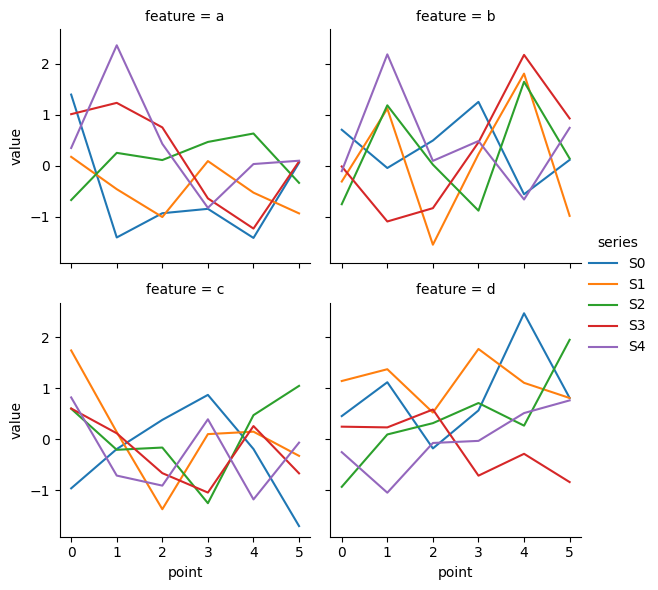

In [21]:
##TEST CODE - Multi plots - DOES NOT USE OUR DATA##
n_points_per_series = 6
n_series_per_feature = 5
n_features = 4

shape = (n_points_per_series, n_features, n_series_per_feature)
data = np.random.randn(*shape).reshape(n_points_per_series, -1)
points = range(n_points_per_series)
features = [chr(ord('a') + i) for i in range(n_features)]
series = [f'S{i}' for i in range(n_series_per_feature)]
index = pd.Index(points, name='point')
columns = pd.MultiIndex.from_product((features, series)).rename(['feature', 'series'])
data = pd.DataFrame(data, index=index, columns=columns)

df = data \
    .stack() \
    .stack() \
    .rename("value") \
    .reset_index()

df.head()

g = sns.FacetGrid(df, col="feature", col_wrap=2, hue="series")
g.map_dataframe(sns.lineplot, x="point", y="value")
g.add_legend()

In [2]:
    ##PLOT TO CHECK THAT FLOW ISN'T ANOMOLY YEAR- NOT INCORPORATED INTO NEW WORKFLOW YET##
#for i in (results.index):
#ax = results.unstack(level=0).plot(kind='line', subplots=True, rot=0, figsize=(9, 7), layout=(2, 3))
#print(results.unstack(level=0).head())
#plt.tight_layout()
#results.reset_index(inplace = True)
plot_df = results.copy()
plot_df.reset_index(inplace = True)
plot_df['year'] = plot_df['datetime'].dt.year
plot_df['date'] = plot_df['datetime'].dt.strftime('%m-%d %H:%M')
unstacked = plot_df.copy()

unstacked = unstacked.set_index(['site_no','year', 'date'])
unstacked.drop(['datetime'], axis=1,inplace=True)

plot_df.drop(['datetime'], axis=1,inplace=True)
display(unstacked)
print((plot_df.head()))



NameError: name 'results' is not defined

                    00065                                               \
site_no          02236125 02244040 02245340 02246000 02246010 02246500   
year date                                                                
2018 07-01 04:00     1.54    10.72    -0.10     7.95    12.05    11.75   
     07-01 04:15     1.54    10.70    -0.01     7.96    12.16    11.80   
     07-01 04:30     1.55    10.69     0.06     7.96    12.30    11.80   
     07-01 04:45     1.56    10.68     0.12     7.94    12.43    11.80   
     07-01 05:00     1.56    10.67     0.16     7.92    12.54    11.84   

                                  
site_no          302309081333001  
year date                         
2018 07-01 04:00            1.40  
     07-01 04:15            1.36  
     07-01 04:30            1.35  
     07-01 04:45            1.28  
     07-01 05:00            1.20  


AttributeError: 'Series' object has no attribute 'stack'

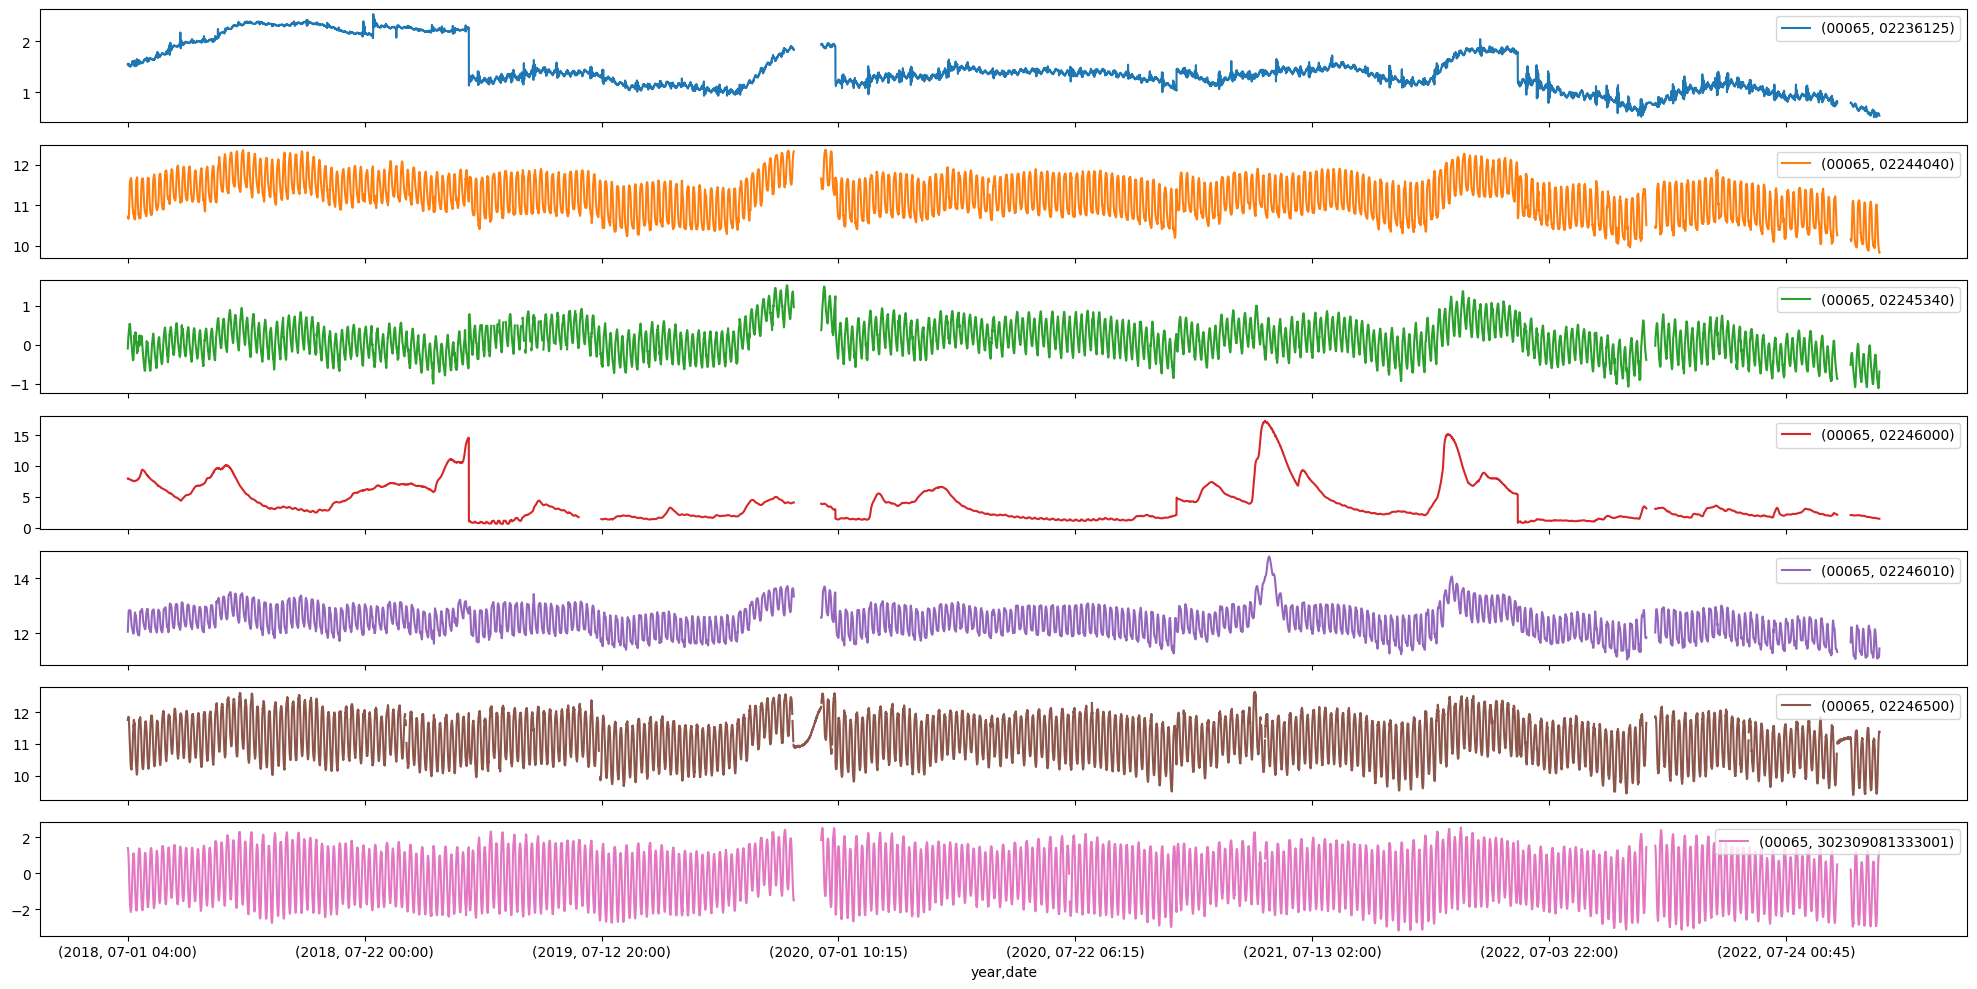

In [154]:
###DOES NOT WORK YET ####


#ax = unstacked.unstack(level=0).plot(kind='line',subplots=True, rot=0, figsize=(9, 7), layout=(2, 3))
ax = unstacked.unstack(level=0).plot(kind='line',subplots=True, rot=0, figsize=(20, 10))
print(unstacked.unstack(level=0).head())
plt.tight_layout()
plot_data = pd.melt(plot_df, id_vars = ['site_no','year'], var_name = '00065')
plot_data = plot_df.stack().stack().rename('value').reset_index
'''
# Create grid and map line plots
g = sns.FacetGrid(plot_df, col="site_no", hue="year")
g.map_dataframe(sns.lineplot, x="date", y="00065")
g.add_legend()


#sns.lineplot(x='date', y='00065', hue  ='year', column ='site_no', data=plot_df, kind = 'line')
#print(plot_data.head())


#fig, axes = plt.subplots(1, 3, figsize=(9, 7), layout = (2,3))
#fig, axes = plt.subplots(1,3)
for i, (j, col) in enumerate(unstacked.iteritems()):
    ax = axes[i]
    col = col.rename_axis([None, None, None])
    col.unstack(fill_value=0).plot(ax=ax, title=j, legend=False)

    if i == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)

fig.tight_layout()



        pv = pd.pivot_table(i, index=results.index.day, columns=results.index.year, values=results.columns[[0]])
        ax = pv.plot(figsize=(13,5))
        ax.legend(loc='lower right')
        ax.set_title('Stage height for USGS Station: '+ str(i)+ ' in July')
        ax.set_xlabel('Day')
        ax.set_ylabel('Streamflow (cfs)')
'''
#Plot for gages for "current year"

C:\Users\RDCHLEKS\AppData\Local\Temp\1\ipykernel_16228\3857556124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_plot.drop(['year'], axis=1, inplace=True)


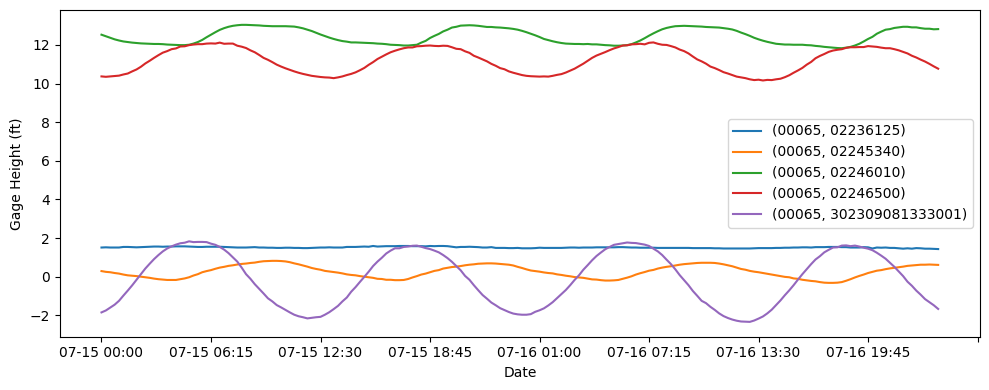

In [178]:
##NOT INCORPORATED TO NEW WORKFLOW YET###
initial_plot = plot_df[plot_df['year']==2021]
initial_plot.drop(['year'], axis=1, inplace=True)
ndata = initial_plot
ndata = initial_plot.loc[initial_plot['date'].between('07-15','07-17')] 
ndata.set_index(['site_no', 'date'], inplace=True)

ax = ndata.unstack(level=0).plot(kind='line',subplots=False, figsize=(10,4))
plt.legend(loc = 'center right')
plt.xlabel('Date')
plt.ylabel('Gage Height (ft)')
plt.tight_layout()

Index(['02236125', '02246010', '02246500', '302309081333001'], dtype='object', name='site_no')
[ 6.36106965e+02+6.34416410e+02j -2.77821598e+04-5.61450732e+04j
 -3.04094461e+05+1.34696405e+05j -1.03446346e+02+3.95579728e+01j
  2.95751142e+03+1.09222806e+05j -2.49069855e+02+3.57922462e+02j
  4.78711405e+02-2.43143586e+02j -1.69838660e+03+3.32933600e+02j
  6.86277248e+03-4.36870232e+04j  6.14629643e+04+6.29217919e+04j
  1.21466560e+05+1.81973828e+05j  7.66669693e+02-4.51794917e+04j
  2.23865748e-03-5.00446516e-03j  2.00187505e+05-6.34055785e+04j
  1.09738050e+02+2.01595511e+01j  2.82858416e+01-3.33394557e+01j
 -1.56696850e+01+1.21027732e+00j  4.79410915e-01+3.31314201e-01j
 -8.19490207e-02-1.11002348e-01j -3.16715275e+03+1.40531035e+03j
  5.16262093e+03-9.52852962e+02j  3.22665954e+01-3.22843084e+01j
  3.81359453e+00-2.33602978e+00j -7.71676540e+00+5.20467144e-01j
 -1.23035692e+02-9.34510232e+01j  7.53813189e+05-1.69595543e+05j
  1.51264616e+04-7.65889141e+04j -5.36083924e+03+1.79218531e

C:\Users\RDCHLEKS\AppData\Local\Temp\1\ipykernel_24460\2535636323.py:23: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  f, vu = wt.compute_nodal_modulations(time.astype("datetime64"))
C:\Users\RDCHLEKS\AppData\Local\Temp\1\ipykernel_24460\2535636323.py:27: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  hp = wt.tide_from_tide_series(time.astype("datetime64"), w)
C:\Users\RDCHLEKS\AppData\Local\Temp\1\ipykernel_24460\2535636323.py:23: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  f, vu = wt.compute_nodal_modulations(time.astype("datetime64"))
C:\Users\RDCHLEKS\AppData\Local\Temp\1\ipykernel_24460\2535636323.py:27: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  hp = wt.tide_from_tide_series(time.astype("datetime64"), w)
C:\Users\RDCHLEKS\AppDat

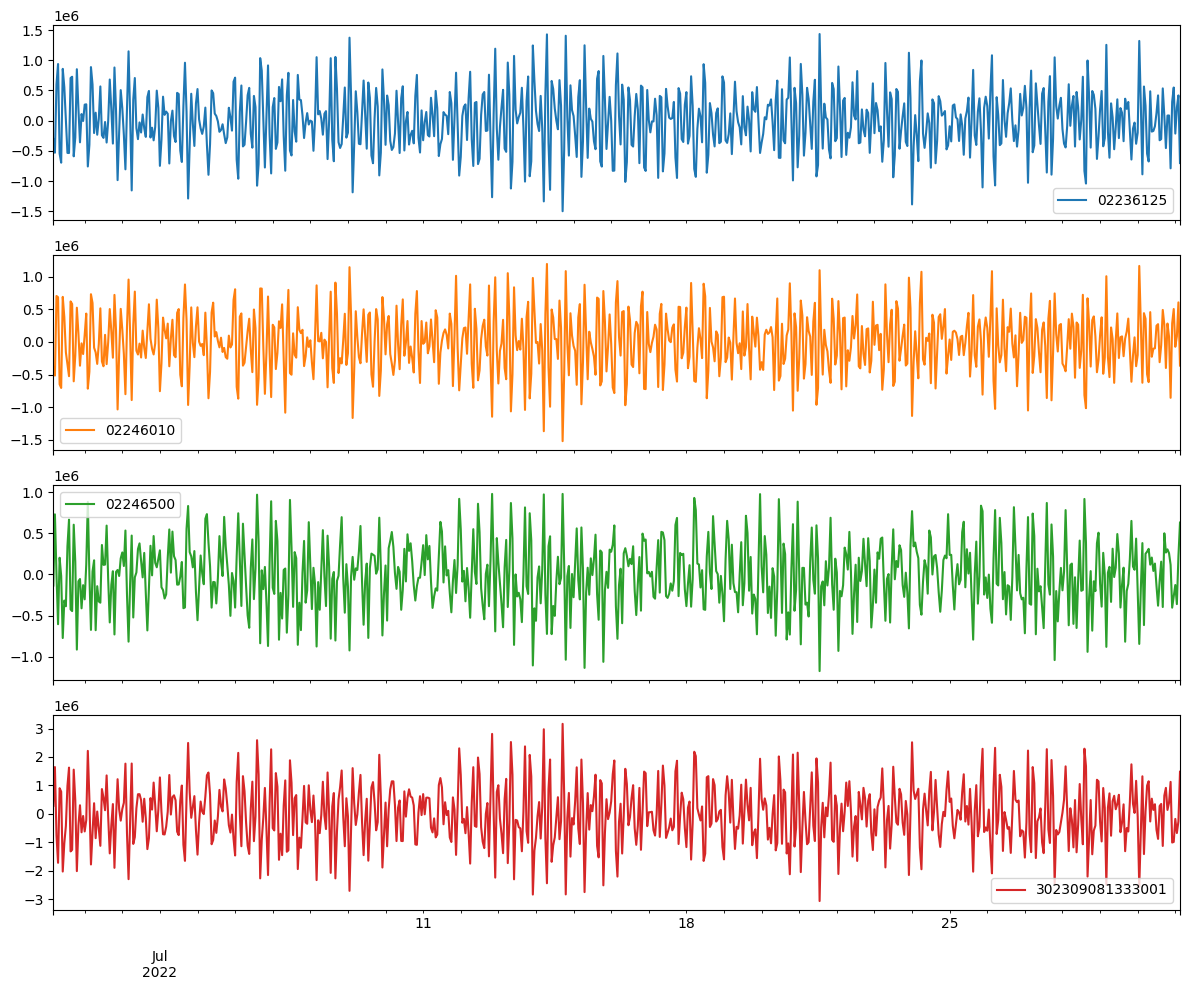

In [37]:
### PYTIDE - DO NOT USE ####
#results.head()
year = 2022
tide_results = pd.DataFrame()
print(results.index.levels[0])
for i in results.index.levels[0]:
    tide_subset = results.loc[[i]].copy()
    tide_subset.reset_index(inplace=True)
    tide_subset.set_index('datetime',inplace=True)
    if year in tide_subset.index.year:
        tide_analys=tide_subset[tide_subset.index.year==year]
    else:
        continue
    tide_analys.reset_index(inplace=True)
    
    #startdate = tide_analys['datetime'][0]
    #enddate = startdate + timedelta(days=7)
    stream_data = tide_analys.groupby([pd.Grouper(key='datetime', freq='H'),'site_no']).mean()
    stream_data.reset_index(inplace=True)

    wt= pytide.WaveTable()
    time = stream_data['datetime'].dt.to_pydatetime()
    
    f, vu = wt.compute_nodal_modulations(time.astype("datetime64"))
    
    w = wt.harmonic_analysis(stream_data['00065'], f, vu)
    print(w)
    hp = wt.tide_from_tide_series(time.astype("datetime64"), w)
    ind_results = pd.DataFrame(data = hp, index = time, columns = [i])
    tide_results = tide_results.join(ind_results, how = 'outer')

#display(tide_results)    
ax = tide_results.plot(kind='line',subplots=True, figsize=(12,10))
#plt.ylabel('Tide Height (ft)')
plt.legend(loc = 'lower right')
plt.tight_layout()

#tidal_results = pd.DataFrame(hp)

# save the dataframe as a csv file


#t_results = tide_pred(results,2022)

In [179]:
### TTIDE FROM WORKSHOP DEMO - DON'T NEED TO RUN FOR NEW WORKFLOW ####
#results.head()
year = 2021
#tide_results_for_scatter = pd.DataFrame()
#tide_results_for_scatter['id'] = results.index.levels[0]

for i in results.index.levels[0]:
    tide_subset = results.loc[[i]].copy()
    tide_subset.reset_index(inplace=True)
    tide_subset.set_index('datetime',inplace=True)
    if year in tide_subset.index.year:
        tide_analys=tide_subset[tide_subset.index.year==year]
    else:
        continue
    tide_analys.reset_index(inplace=True)
    
    #startdate = tide_analys['datetime'][0]
    #enddate = startdate + timedelta(days=7)
    stream_data = tide_analys.groupby([pd.Grouper(key='datetime', freq='H'),'site_no']).mean()
    stream_data.reset_index(inplace=True)
    
    stream_data['demean'] = stream_data['00065'] - stream_data['00065'].mean()
    tfit_e = t_tide(stream_data['demean'].values, out_style='classic')

    tfit_e = t_tide(stream_data['demean'].values, out_style='pandas', outfile='test_'+str(i)+'.csv')
    


-----------------------------------
nobs = 720 
ngood = 719 
record length (days) = 30.00
rayleigh criterion = 1.0

Phases at central time
x0= -0.00186  xtrend= 0
var(data)= 0.04    var(prediction)= 0.00    var(residual)= 0.04
var(prediction)/var(data) (%) = 1.2

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
  MSF   0.0028219     0.2267     0.188    294.59     47.19       1.5
  2Q1   0.0357064     0.0030     0.005    197.32    123.48      0.31
  Q1    0.0372185     0.0013     0.004     41.32    178.65     0.092
  O1    0.0387307     0.0053     0.005    301.53     67.15       1.1
  NO1   0.0402686     0.0038     0.005    196.86     80.66      0.52
* K1    0.0417807     0.0128     0.007    244.01     30.35       3.3
  J1    0.0432929     0.0054     0.006    100.76     58.78      0.91
  OO1   0.0448308     0.0046     0.006    211.15     84.77      0.63
  UPS1  0.0463430     0.0043     0.005    167.12     81.88   

In [180]:
#FOR PlOTTING RELATIONSHIP BETWEEN GAGE SITES##

harm_analysis_02236125 = pd.read_csv('test_02236125.csv', header = 9, sep='\s{2,}', engine = 'python')
harm_analysis_02246010 = pd.read_csv('test_02246010.csv', header = 9, sep='\s{2,}', engine = 'python')
harm_analysis_02246500 = pd.read_csv('test_02246500.csv', header = 9, sep='\s{2,}', engine = 'python')
harm_analysis_302309081333001 = pd.read_csv('test_302309081333001.csv', header = 9, sep='\s{2,}', engine = 'python')
harm_analysis_2245340 = pd.read_csv('test_02245340.csv', header = 9, sep='\s{2,}', engine = 'python')
#harm_analysis_302309081333001 = pd.read_csv('test_302309081333001.csv', header = 9, sep='\s{2,}', engine = 'python')
#harm_analysis_302309081333001 = pd.read_csv('test_302309081333001.csv', header = 9, sep='\s{2,}', engine = 'python')

analyses = {'harm_analysis_302309081333001':harm_analysis_302309081333001, 'harm_analysis_02246500':harm_analysis_02246500,  'harm_analysis_02246010':harm_analysis_02246010, 'harm_analysis_02236125':harm_analysis_02236125, 'harm_analysis_2245340': harm_analysis_2245340}
#print((analyses))

tide_results_for_scatter = pd.DataFrame()

#display(harm_analysis_02236125.head())
#display(harm_analysis_02246010.head())
#display(harm_analysis_02246500.head())
#display(harm_analysis_302309081333001.head())
#for i in results.index.levels[0]:
for key, val in analyses.items():
    #print(val)
    #print([k for k, j in locals().items() )
    #print(val.loc[['M2','K1','O1'],'Amp'])
    tide_results_for_scatter[key]= val.loc[['M2','K1','O1'],'Amp']
    #tide_results_for_scatter ['']
    #display(tide_results_for_scatter)
riv_mi = pd.read_csv('Demo/gage_info.csv', header =1)
riv_mi.set_index('Site No.', inplace = True)
riv_mi_vals = riv_mi['Riv Mi'][::-1]
#if tide_results_for_scatter.columns. is in (riv_mi['Site No.']):
    #tide_results_for_scatter['riv mi'] = riv_mi['Riv Mi']
#for i in tide_results_for_scatter.columns:
    
#tide_results_for_scatter['Riv Mi'].apply(lambda x: )
tide_results_for_scatter.loc['riv id'] = riv_mi_vals.values

tide_results_for_scatter.reset_index(inplace=True)
pd.melt(tide_results_for_scatter)
display(tide_results_for_scatter)

,Tide,harm_analysis_302309081333001,harm_analysis_02246500,harm_analysis_02246010,harm_analysis_02236125,harm_analysis_2245340
0,M2,1.89,0.86,0.46,0.03,0.43
1,K1,0.29,0.14,0.10,0.01,0.10
2,O1,0.18,0.09,0.08,0.01,0.08
3,riv id,11.00,24.00,61.00,NaN,129.75


In [171]:
#SITE INFO## 

siteINFO_multi = nwis.get_info(sites=stations)
display(siteINFO_multi[0])
siteINFO_multi[0].to_csv("siteinfo.")

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,local_time_fg,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
0,USGS,02236125,"ST. JOHNS RIVER AT ASTOR, FL",ST,291000.00,813120.00,29.166924,-81.522016,M,S,...,Y,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USGS,02245340,"ST JOHNS R BLW SHANDS BRIDGE NR GRN COVE SPRG, FL",ST,300021.32,813654.49,30.005922,-81.615136,G,S,...,Y,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USGS,02246010,"NORTH FORK BLACK CREEK AT MIDDLEBURG, FL",ST,300433.00,815150.00,30.076073,-81.863711,M,S,...,Y,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,101.0
3,USGS,02246500,"ST. JOHNS RIVER AT JACKSONVILLE, FL",ST,301920.00,813956.00,30.322462,-81.665374,M,S,...,Y,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,101.0
4,USGS,302309081333001,"ST JOHNS R DAMES POINT BRIDGE AT JACKSONVILLE, FL",ST,302309.00,813330.00,30.386073,-81.558147,M,S,...,Y,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
##IGNORE THIS CELL ## 

center = [40.5,-92.77155]
zoom = 5
gageMap = folium.Map(basemap=basemaps.CartoDB.Positron, location=center, zoom_start=zoom, control_scale=True)

marker_cluster = folium.plugins.MarkerCluster(name="Gages").add_to(gageMap)
for index,row in gage_sites.iterrows():
    popup = folium.Popup(('<b>Site ID: </b>'+str(row.site_no)+ '<br><b>Station Name: </b>'+ str(row.station_nm)), max_width=200)
    folium.Marker(location=[row.dec_lat_va, row.dec_long_va],popup=popup).add_to(marker_cluster)

gageMap

NameError: name 'folium' is not defined